In [51]:
from autograd import grad as compute_grad   
import autograd.numpy as np
import numpy as npo
import copy
from autograd import grad as compute_grad   
from datetime import datetime 

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test transformation on face images

Load in data, transform via original method, transform via new method, compare features to make sure everything looks good.

In [52]:
 def load_data(datapath):
    # load in data
    data = np.loadtxt(datapath,delimiter = ',')

    # import data and reshape appropriately
    X = data[:,:-1]
    y = data[:,-1:]
    
    return X,y

Load in the data, and produce image tensor.

In [53]:
# load data
datapath = '../../mlrefined_datasets/convnet_datasets/feat_face_data.csv'
X, y = load_data(datapath)

Lets just examine a subset of the images.

In [54]:
ind = np.random.permutation(len(y))

In [55]:
x = X[ind[:1000],:]
y = y[ind[:1000]]

# Tensor-based version

In [88]:
class tensor_conv_layer:
    def load_data(self,x,y):
        self.x = x
        self.y = y
    
    # convolution function
    def conv_function(self,tensor_window):
        tensor_window = np.reshape(tensor_window,(np.shape(tensor_window)[0],np.shape(tensor_window)[1]*np.shape(tensor_window)[2]))
        t = np.dot(self.kernels,tensor_window.T)
        return t

    # pooling / downsampling parameters
    def pool_function(self,tensor_window):
        t = np.max(tensor_window,axis = (1,2))
        return t

    # activation 
    def activation(self,tensor_window):
        return np.maximum(0,tensor_window)

    # pad image with appropriate number of zeros for convolution
    def pad_tensor(self,tensor,kernel_size):
        odd_nums = np.array([int(2*n + 1) for n in range(100)])
        pad_val = np.argwhere(odd_nums == kernel_size)[0][0]
        tensor_padded = np.zeros((np.shape(tensor)[0], np.shape(tensor)[1] + 2*pad_val,np.shape(tensor)[2] + 2*pad_val))
        tensor_padded[:,pad_val:-pad_val,pad_val:-pad_val] = tensor
        return tensor_padded    
    
    # sliding window for image augmentation
    def sliding_window_tensor(self,tensor,window_size,stride,func):
        # grab image size, set container for results
        image_size = np.shape(tensor)[1]
        results = []
        
        # slide window over input image with given window size / stride and function
        for i in np.arange(0, image_size - window_size + 1, stride):
            for j in np.arange(0, image_size - window_size + 1, stride):
                # take a window of input tensor
                tensor_window =  tensor[:,i:i+window_size, j:j+window_size]
                
                # now process entire windowed tensor at once
                tensor_window = np.array(tensor_window)
                yo = func(tensor_window)

                # store weight
                results.append(yo)
        
        # re-shape properly
        results = np.array(results)
        results = results.swapaxes(0,1)
        if func == self.conv_function:
            results = results.swapaxes(1,2)

        ##results = np.reshape(results,(np.shape(results)[0]*np.shape(results)[1],np.shape(results)[2]*np.shape(results)[3]))   
        # return results in numpy array format
        return results 

    # make feature map
    def make_feature_tensor(self,tensor):
        # create feature map via convolution --> returns flattened convolution calculations
        conv_stride = 1
        feature_tensor = self.sliding_window_tensor(tensor,self.kernel_size,conv_stride,self.conv_function) 

        # re-shape convolution output ---> to square of same size as original input
        num_filters = np.shape(feature_tensor)[0]
        num_images = np.shape(feature_tensor)[1]
        square_dim = int((np.shape(feature_tensor)[2])**(0.5))
        feature_tensor = np.reshape(feature_tensor,(num_filters,num_images,square_dim,square_dim))
        
        # shove feature map through nonlinearity
        feature_tensor = self.activation(feature_tensor)

        # pool feature map --- i.e., downsample it
        pool_stride = 3
        pool_window_size = 6
        downsampled_feature_map = []
        for t in range(np.shape(feature_tensor)[0]):
            temp_tens = feature_tensor[t,:,:,:]
            d = self.sliding_window_tensor(temp_tens,pool_window_size,pool_stride,self.pool_function)
            downsampled_feature_map.append(d)
        downsampled_feature_map = np.array(downsampled_feature_map)

        # return downsampled feature map --> flattened
        return downsampled_feature_map

    # our normalization function
    def normalize(self,data,data_mean,data_std):
        normalized_data = (data - data_mean)/(data_std + 10**(-5))
        return normalized_data

    # convolution layer
    def conv_layer(self,tensor,kernels):
        #### prep input tensor #####
        # pluck out dimensions for image-tensor reshape
        num_images = np.shape(tensor)[0]
        num_kernels = np.shape(kernels)[0]
        
        # create tensor out of input images (assumed to be stacked vertically as columns)
        tensor = np.reshape(tensor,(np.shape(tensor)[0],int((np.shape(tensor)[1])**(0.5)),int( (np.shape(tensor)[1])**(0.5))),order = 'F')

        # pad tensor
        kernel = kernels[0]
        self.kernel_size = np.shape(kernel)[0]
        padded_tensor = self.pad_tensor(tensor,self.kernel_size)

        #### prep kernels - reshape into array for more effecient computation ####
        self.kernels = np.reshape(kernels,(np.shape(kernels)[0],np.shape(kernels)[1]*np.shape(kernels)[2]))
        
        #### compute convolution feature maps / downsample via pooling one map at a time over entire tensor #####
        # compute feature map for current image using current convolution kernel
        feature_tensor = self.make_feature_tensor(padded_tensor)

        feature_tensor = feature_tensor.swapaxes(0,1)
        feature_tensor = np.reshape(feature_tensor, (np.shape(feature_tensor)[0],np.shape(feature_tensor)[1]*np.shape(feature_tensor)[2]),order = 'F')
        
        return feature_tensor
    
    def predict(self,x,w):
        # pass input data through convolutional layer
        x_conv = self.conv_layer(x,w[0])
        
        # take inner product against output of conv layer
        value = w[1][0] + np.dot(x_conv,w[1][1:])
        return value
    
    # the softmax cost function 
    def softmax(self,w):
        cost  = np.sum(np.log(1 + np.exp((-self.y)*(self.predict(self.x,w)))))
        return cost
    
    def count(self,w):
        return 0.25*np.sum((np.sign(self.predict(self.x,w)) - self.y)**2)

# Gradient descent

In [84]:
from autograd.misc.flatten import flatten
from autograd.misc.flatten import flatten_func

# gradient descent function
def gradient_descent(g,w_unflat,alpha,max_its,version,**kwargs):
    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']

    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w_unflat)
    grad = compute_grad(g)

    # record history
    w_hist = []
    w_hist.append(w_unflat)

    # over the line
    for k in range(max_its):   
        if verbose == True:
            if np.mod(k,5) == 0:
                print ('started step ' + str(k) + ' of ' + str(max_its))
                
        # plug in value into func and derivative
        grad_eval = grad(w_unflat)
        grad_eval, _ = flatten(grad_eval)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm

        # take descent step 
        w = w - alpha*grad_eval

        # record weight update
        w_unflat = unflatten(w)
        w_hist.append(w_unflat)
        
    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')
#     if verbose == True:
#         print ('...optimization complete!')
#         time.sleep(1.5)
#         clear_output()

    return w_hist

In [85]:
# random initialization for kernels
scale = 0.1
kernels = scale*np.random.randn(8,3,3) 

# initialize instance of convnet
tensor_test = tensor_conv_layer()
tensor_test.load_data(x,y)

# run a small set of images through the network to collect final weights size
final_features = tensor_test.conv_layer(x,kernels)
final_size = np.shape(final_features)[1] + 1

# set final weights 
final_weights = scale*np.random.randn(final_size,1)
weights = [kernels,final_weights]

In [86]:
startTime= datetime.now() 

# run standard (full) gradient descent
g = tensor_test.softmax
w = weights
alpha = 10**(-1)
max_its = 2
version = 'normalized'
weight_history_1 =  gradient_descent(g,w,alpha,max_its,version,verbose = True)

timeElapsed=datetime.now()-startTime 

print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))

started step 0 of 2
(1000, 512)
(512,)
(1000, 512)
(512,)


/Users/Nurgetson/anaconda/lib/python3.5/site-packages/autograd/numpy/numpy_vjps.py:268: RuntimeWarning: invalid value encountered in true_divide
  g_repeated, num_reps = repeat_to_match_shape(g / ans, shape, dtype, axis, keepdims)


finished all 2 steps
Time elpased (hh:mm:ss.ms) 0:00:07.332165


In [69]:
# import plotting library and other necessities
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

# our plotting function
def plot_history(x,y,weight_histories,soft,count):
    '''
    A module for computing / plotting the cost and misclassification histories for a given run of gradient descent.
    Here the input should be the data and weight history from a gradient descent run
    '''
    
    # initialize figure
    fig = plt.figure(figsize = (9,3))

    # create subplot with 3 panels, plot input function in center plot
    gs = gridspec.GridSpec(1, 2) 
    ax1 = plt.subplot(gs[0]); 
    ax2 = plt.subplot(gs[1]);
    
    # loop over histories and plot all
    c = 1
    for weight_history in weight_histories:
        # loop over input weight history and create associated cost and misclassification histories
        cost_history = []
        count_history = []
        for weight in weight_history:
            cost_val = soft(weight)
            cost_history.append(cost_val)

            count_val = count(weight)
            count_history.append(count_val)

        # now plot each, one per panel
        ax1.plot(cost_history)  
        label = 'full grad'
        if c == 2:
            label = 'mini-batch'
        if c == 3:
            label = 'stochastic'
        ax2.plot(count_history,label = label)
        c+=1
        
    # label each panel
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('cost function val')
    ax1.set_title('cost function history')
    
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('misclassifications')
    ax2.set_title('number of misclassificaions')
    
    ax2.legend()
    
    plt.show()

<IPython.core.display.Javascript object>


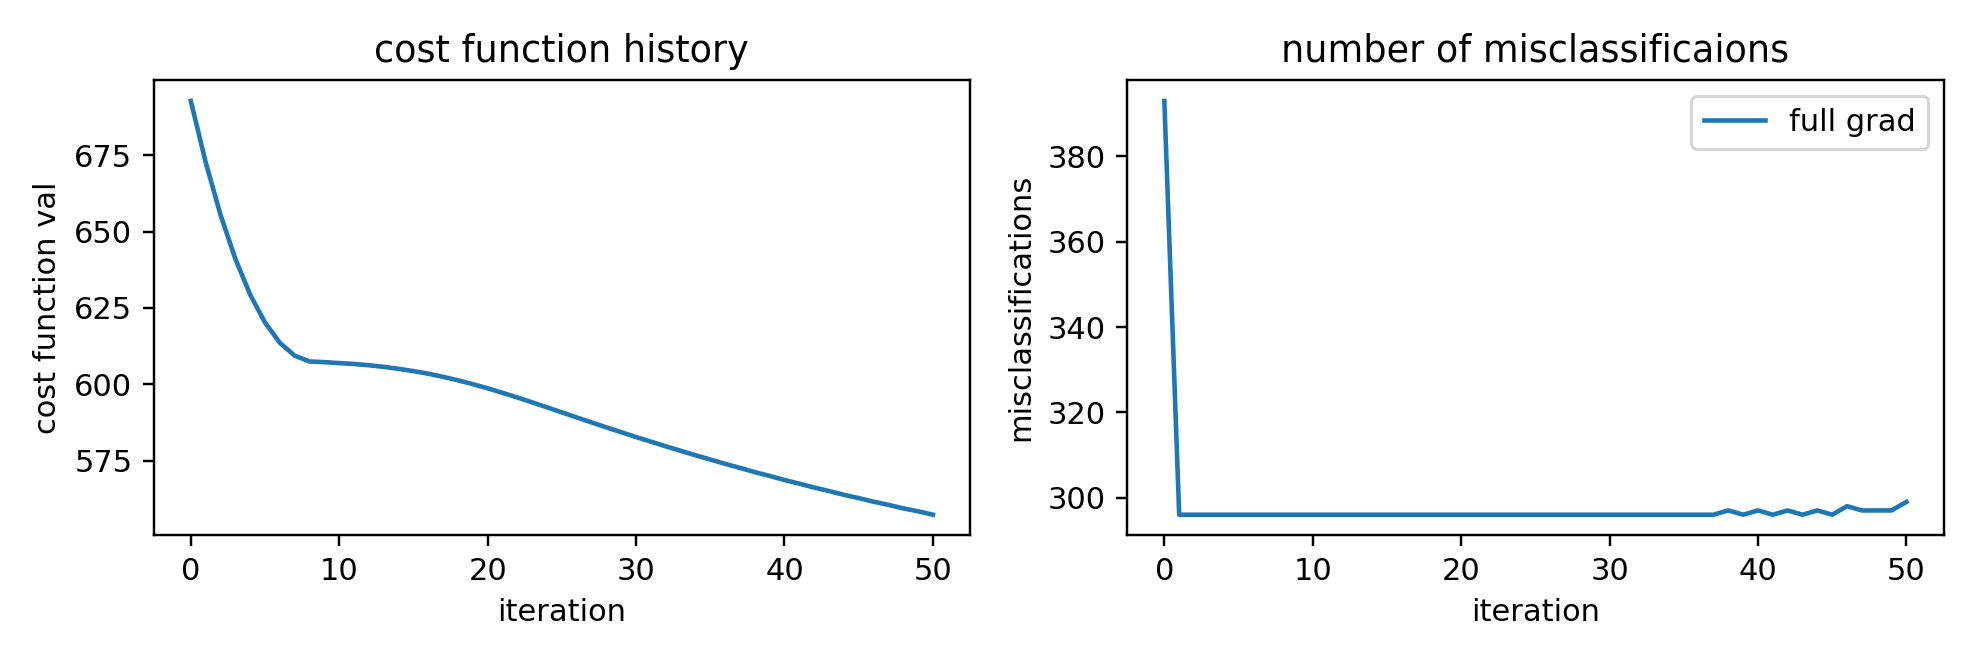

In [70]:
weight_histories = [weight_history_1]
plot_history(x,y,weight_histories,tensor_test.softmax,tensor_test.count)